# 4IF Data Mining Lab
Nadine Saadalla, Noémie Varjabedian, Eléonore Dravet  
February 2025


# Introduction
During this Data Mining project, we will be analyzing the geolocation data of photographs taken in the Grand Lyon. The data comes from the Flickr database and was taken between 2010 and 2019. We will explore different clustering methods to identify areas of interest for tourism in the metropolis, i.e. areas where many photographs are taken. Finally, we'll work on photograph captions to assign descriptions to our areas of interest

# Python set-up

In this section, we will set up a virtual python environment and install all necessary packages to run the code.

In [ ]:
! source ./vitualenvpython/bin/activate
! which python3


In [ ]:
# installation of required libraries and dependencies
# numeric calculations
! pip install numpy==1.26.0 
# data frames 
! pip install pandas==2.1.1 
# machine learning algorithms 
! pip install scikit-learn==1.5.1 
! pip install scipy==1.12.0
# plotting 
! pip install plotly==5.24.1 
! pip install matplotlib==3.8.0 
! pip install plotly-express==0.4.1 
! pip install chart-studio==1.1.0 
# web app library 
! pip install streamlit==1.37.1 
#maping library
! pip install folium
# association rules
! pip install mlxtend==0.23.3

! pip install nbformat==5.9.2 

In [3]:
# load pandas to deal with the data
import pandas as pd
# plotting
import matplotlib.pyplot as plt
import folium
import numpy as np

# Data loading and cleaning

We start by viewing the current dataset.

In [4]:
data = pd.read_table("flickr_data2.csv", sep=",")
data.head()

/tmp/ipykernel_21015/1115438621.py:1: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_table("flickr_data2.csv", sep=",")


id          user        lat      long  \
0  4395181099  30624617@N03  45.754858  4.821710   
1  4394748717  35853470@N00  45.753270  4.862953   
2  4394694699  11817998@N05  45.760655  4.846564   
3  4394803790  11545749@N06  45.784000  4.874072   
4  4394803554  11545749@N06  45.784000  4.874072   

                                                tags  \
0                 chair,lyon,rhône,chaise,rhônealpes   
1                                                NaN   
2                                         365,iphone   
3       nin,nineinchnails,gift,screening,toiou,avott   
4  lyon,nin,nineinchnails,gift,screening,toiou,avott   

                         title   date_taken_minute   date_taken_hour  \
0             Chaises avec vue                11.0                15   
1                          NaN                51.0                17   
2       59/365 - R46 V103 B163                29.0                17   
3  2010-01-29 Toiou Avott Lyon                15.0                20   
4  2010-01-28 Toiou Avott Lyon                10.0                20   

    date_taken_day   date_taken_month   date_taken_year  date_upload_minute  \
0               28                  2              2010                  23   
1               28                  2              2010                  52   
2               28                  2              2010                  33   
3               28                  1              2010                  38   
4               28                  1              2010                  38   

   date_upload_hour   date_upload_day   date_upload_month   date_upload_year  \
0                20              28.0                   2             2010.0   
1                17              28.0                   2             2010.0   
2                17              28.0                   2             2010.0   
3                12              28.0                   2             2010.0   
4                12              28.0                   2             2010.0   

   Unnamed: 16  Unnamed: 17  Unnamed: 18  
0          NaN          NaN          NaN  
1          NaN          NaN          NaN  
2          NaN          NaN          NaN  
3          NaN          NaN          NaN  
4          NaN          NaN          NaN

### Cleaning data in unnamed columns

In [ ]:
data.info()

We notice the three lines    

16  Unnamed: 16          142 non-null     float64  
17  Unnamed: 17          0 non-null       float64  
18  Unnamed: 18          2 non-null       float64  

which indicate that some lines have values in unnamed columns, probably due to a wrong use of the separators ','. They represent a very small ration of the overall data (~150/420 000) so we chose to delete those lines without further investigation. 

In [ ]:
unnamed_columns = data.columns[data.columns.str.contains('^Unnamed')]
data = data.loc[~data["Unnamed: 16"].notna(),:]
data = data.loc[~data["Unnamed: 17"].notna(),:]
data = data.loc[~data["Unnamed: 18"].notna(),:]
data.info()

The lines have been deleted ("0 non-null"). The columns still appear, we can delete them. 

In [ ]:
data=data.drop(columns=unnamed_columns)
data.info()

### Spaces

We notice that except for 'id', the column names start with a space. To manipulate the columns more easily, we remove these spaces. 

In [ ]:
data=data.rename(columns=lambda x: x.strip())

### Incoherent values
We can look at the statistics to check that they are coherent.

In [ ]:
data.describe()

We see that the max date_taken_year is 2238, which is impossible. This pushes us to delete all rows where the date taken is more than 2025 (the current year), and print all the years where pictures have been taken in our dataset, to check that everything is coherent.


In [ ]:
index=data[data['date_taken_year']>2025].index
data.drop(index=index,axis=1)
taken_years = data["date_taken_year"].unique()
uploded_years = data["date_upload_year"].unique()
print(f" When pictures are taken : {taken_years}\n")
print(f" When pictures are uploaded : {uploded_years}")

<a id="missing-vals"></a>
### Missing Values

In [ ]:
data.isna().sum()

We see that the missing values are either from the tags, the title or the upload_year. For our analysis on the coordinates, these information are not determining and we can choose to keep the corresponding data. However, in order to run our algorithm, we sample the data (our CPUs are not powerful enough to run with all the data) and keep only a thousand points, so we may as well keep the data with tags for our text analysis later.

In [ ]:
data=data.drop(index=data[data['tags'].isna()].index)

<a id="duplicates"></a>
### Duplicates

For our analysis to be pertinent, we do not want to count several times pictures taken by the same person, in the same place, in the same hour. This allows us to count visits. This avoids getting influenced by someone taking burst photos as well. Hence we remove the duplicates using the following columns. 

In [ ]:
columns_for_duplicates=['user', 'lat', 'long','date_taken_hour', 'date_taken_day', 'date_taken_month','date_taken_year', 'date_upload_minute', 'date_upload_hour','date_upload_day', 'date_upload_month', 'date_upload_year']
data=data.drop_duplicates(subset=columns_for_duplicates)

We now have ~90 00 points from the ~420 000 initial. We still have enough values. 

In [ ]:
data.info()

We can visualize all the points on a map as a last check of our values. We choose 1000 random tagged points.

In [ ]:
m = folium.Map([45.762611,4.832805	], zoom_start=14)
data_sample = data.sample(1000)

for index, row in data_sample.iterrows():
    folium.Marker(
        location=[row["lat"],row["long"]],
        icon=folium.DivIcon(html=f"""<svg width="20px" height="20px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
        <path d="M12 9.5C13.3807 9.5 14.5 10.6193 14.5 12C14.5 13.3807 13.3807 14.5 12 14.5C10.6193 14.5 9.5 13.3807 9.5 12C9.5 10.6193 10.6193 9.5 12 9.5Z" fill="#e63946"/>
        </svg>""")
    ).add_to(m)

m

Everything looks cleaned. We can save our cleaned data to a new csv and work with this version as for now. We will not have do do the treatment again since we can just directly use the data_cleaned.csv. 

In [ ]:
data.to_csv('./data_cleaned.csv',index=False)

# Analyzing clsutering methods

In [8]:

data_cleaned=pd.read_csv('./data_cleaned.csv')
data_sample = data_cleaned.sample(1000, random_state=42)
cluster_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#FFA500', '#800080']

## k-means Clustering and Find the Optimal Number of Clusters using Elbow Method

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull, QhullError
import folium

Before using the Elbow method, we observe the different clusters we obtain by changing the value of k. 

### Elbow method 
We use the elbow method to determine the best parameter k for our K-Means clustering.

In [ ]:
inertias = []
for i in range(1,30):
  kmeans=KMeans(n_clusters=i,init='k-means++')
  kmeans.fit(data_sample[["lat", "long"]])
  inertias.append(kmeans.inertia_)

plt.plot(range(1,30),inertias)
plt.show()

The optimal value seems to be k=7. When we visualize the result on the map, there are not enough clusters to represent touristic places. We hence chose to use a higher k to adapt to the reality.

P.S. : We only show clusters than contain more than 10 points. Samller clusters are considered irrelevant. This changes nothing for k=7 but for a bigger k or for other methods, this rule has an impact on the printed map.

### k-means = 7 | 100 maps

In [ ]:
k = 7

kmeans = KMeans(n_clusters=k, init='k-means++')
kmeans.fit(data_sample[["lat", "long"]])

m = folium.Map(location=[45.762611, 4.832805], zoom_start=14)

labels = kmeans.labels_

clustered_points = data_sample.assign(cluster=labels)

for cluster_id in clustered_points['cluster'].unique():
    cluster_points = clustered_points[clustered_points['cluster'] == cluster_id]
    points = cluster_points[['lat', 'long']].values

    if len(points) >= 10:  # We only show clusters with more than 10 points.
        try:
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]  
            
            
            folium.Polygon(
                locations=hull_points,
                color=cluster_colors[cluster_id % len(cluster_colors)],
                weight=2,
                fill=True,
                fill_opacity=0.2
            ).add_to(m)
        except QhullError:
            print(f"Cluster {cluster_id}: QhullError occurred; skipping hull computation.")
    else:
        print(f"Cluster {cluster_id}: Less than 10 points; skipping perimeter.")

for _, row in data_sample.iterrows():
    folium.Marker(
        location=[row["lat"], row["long"]],
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="black"/>
        </svg>
        """)
    ).add_to(m)

m.save("cluster_map_k_means_7.html")


In [ ]:
k = 100

kmeans = KMeans(n_clusters=k, init='k-means++')
kmeans.fit(data_sample[["lat", "long"]])

m = folium.Map(location=[45.762611, 4.832805], zoom_start=14)

labels = kmeans.labels_

clustered_points = data_sample.assign(cluster=labels)

for cluster_id in clustered_points['cluster'].unique():
    cluster_points = clustered_points[clustered_points['cluster'] == cluster_id]
    points = cluster_points[['lat', 'long']].values

    if len(points) >= 10:  # We only show clusters with more than 10 points.
        try:
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]  
            
            
            folium.Polygon(
                locations=hull_points,
                color=cluster_colors[cluster_id % len(cluster_colors)],
                weight=2,
                fill=True,
                fill_opacity=0.2
            ).add_to(m)
        except QhullError:
            print(f"Cluster {cluster_id}: QhullError occurred; skipping hull computation.")
    else:
        print(f"Cluster {cluster_id}: Less than 10 points; skipping perimeter.")

for _, row in data_sample.iterrows():
    folium.Marker(
        location=[row["lat"], row["long"]],
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="black"/>
        </svg>
        """)
    ).add_to(m)

m.save("cluster_map_k_means_100.html")


## Task #5: Cluster Evaluation using Silhouette Coefficient | A FAIRE

To evaluate the quality of the clustering, we can use **Silhouette Coefficient**. The Silhouette Coefficient for a sample is given by $(b - a) / max(a, b)$ where `b` is the distance between a sample and the nearest cluster that the sample is not a part of, and `a` is the mean intra-cluster distance (i.e. the mean distance between a sample and all other samples in the same cluster). 

The silhouette score ranges from -1 to 1 and indicates how well each data point fits within its assigned cluster:

* Score near +1 means:
    - The data point is far from neighboring clusters
    - The point is well-matched to its cluster
    - Indicates very distinct, well-separated clustering
* Score near 0 means:
    - The data point is close to the decision boundary between clusters
    - The point could potentially belong to either cluster
    - Suggests overlapping or not well-defined clusters
* Score near -1 means:
    - The data point might be assigned to the wrong cluster
    - The point is closer to points in another cluster than its own
    - Indicates poor clustering or potential misassignments

We can use [`sklearn.metrics.silhouette_score`](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.silhouette_score.html) and [`sklearn.metrics.silhouette_samples`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html)

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples

**QUESTIONS**

* For k-means clustering with `k=3`, calculate Silhouette score for each data point, for each cluster and average silhouette score 
* Display Silhouette score plot
* Comment

In [ ]:
kmeans=KMeans(n_clusters=3,init='k-means++')
for_silhouette_df = scaled_data_df.copy()
for_silhouette_df["labels"] = labels

for_silhouette_df = for_silhouette_df.sort_values(by=["labels"])

for_silhouette_df["silhouettes"] = silhouette_samples(for_silhouette_df[features],for_silhouette_df["labels"])

cluster_silhouette_score = for_silhouette_df.groupby(["labels"]).mean()["silhouettes"]

average_silhouette_score = for_silhouette_df["silhouettes"].mean()

In [ ]:
import matplotlib.cm as cm

In [ ]:
fig = plt.figure(figsize = (20,20))
fig, (ax1) = plt.subplots(1, 1)
y_lower = 10
for i in range(3):
    ith_cluster_silhouette_values = for_silhouette_df.loc[for_silhouette_df["labels"] == i]

    ith_cluster_silhouette_values.sort_values(by=["silhouettes"])

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 3)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

ax1.axvline(x=average_silhouette_score, color="red", linestyle="--")

ax1.set_yticks([]) 
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [ ]:
# ANSWER


As general guidelines, the plot can be interpreted by looking at:
* *the thickness of the clusters (number of points)*;
* check if any cluster has many negative values;
* check the consistency of the silhouette widths within clusters;
* the average value. Recall that in general, the following interpretation applies:
    - \> 0.7: Strong clustering structure
    - 0.5 - 0.7: Reasonable clustering structure
    - 0.25 - 0.5: Weak clustering structure
    - < 0.25: No substantial clustering structure


* Cluster Silhouette scores. 

YOUR COMMENT: TO COMPLETE

## Hierarchical Clustering : single, complete and ward

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In this part, we analyse the 3 variations of hierarchical clustering.

In [ ]:
clustering_single = AgglomerativeClustering(n_clusters=100, linkage='single').fit(data_sample[["lat", "long"]] )

In [ ]:
clustering_complete = AgglomerativeClustering(n_clusters=100, linkage='complete').fit(data_sample[["lat", "long"]] )

In [ ]:
clustering_ward = AgglomerativeClustering(n_clusters=100, linkage='ward').fit(data_sample[["lat", "long"]] )

After observing on the map the different results, we determine that the best hierarchical cluserting method is the ward one. 

In [ ]:
print(clustering_ward.labels_)

In [ ]:
from collections import Counter


m = folium.Map(location=[45.762611, 4.832805], zoom_start=14)

labels = clustering_ward.labels_

clustered_points = data_sample.assign(cluster=labels)


cluster_names = {}

for cluster_id in clustered_points['cluster'].unique():
    if cluster_id < 2:
        print(f"Skipping cluster {cluster_id} (outlier)")
        continue

    cluster_points = clustered_points[clustered_points['cluster'] == cluster_id]

    excluded_tags = {"lyon", "france", "europe", "francia", "rhône", "auvergnerhônealpes", "fra", "iphoneography", "rhôneaples", "frankreich", "frankrig"}  # Tags to ignore
    all_tags = []
    for tags in cluster_points['tags'].dropna():  # Drop empty tag entries
        filtered_tags = [tag for tag in tags.split(',') if tag.lower().strip() not in excluded_tags]
        all_tags.extend(filtered_tags)

    # Determine the most common tag(s)
    if all_tags:
        tag_counts = Counter(all_tags)
        most_common_tags = [tag for tag, count in tag_counts.most_common(3)]  # Top 3 tags
        cluster_name = ', '.join(most_common_tags)  # Combine for naming
    else:
        cluster_name = f"Cluster {cluster_id}"  # Default name if no tags available

    # Store the name for this cluster
    cluster_names[cluster_id] = cluster_name
    print(f"Cluster {cluster_id} named: {cluster_name}")


    points = cluster_points[['lat', 'long']].values

    if len(points) >= 10: 
        try:
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]
            
            folium.Polygon(
                locations=hull_points,
                color=cluster_colors[cluster_id % len(cluster_colors)], 
                weight=2,
                fill=True,
                fill_opacity=0.2,
                tooltip=cluster_names[cluster_id]
            ).add_to(m)
        except QhullError:
            print(f"Cluster {cluster_id}: QhullError occurred; skipping hull computation.")
    else:
        print(f"Cluster {cluster_id}: Less than 3 points; skipping perimeter.")

for _, row in data_sample.iterrows():
    folium.Marker(
        location=[row["lat"], row["long"]],
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="black"/>
        </svg>
        """),
        tooltip=row["tags"]  # Show tags on hover
    ).add_to(m)

m.save("cluster_map_clustering_ward.html")
m

In [ ]:

import requests

# Flickr API details
FLICKR_API_KEY = "c9f9183c6f9f862b589a12aa27b9c8e6"
FLICKR_SECRET = "f46c69ef000f0202"

# Function to get the photo's server-id and secret from Flickr API
def get_flickr_image_url(photo_id):
    url = "https://api.flickr.com/services/rest/"
    params = {
        "method": "flickr.photos.getInfo",
        "api_key": FLICKR_API_KEY,
        "photo_id": photo_id,
        "format": "json",
        "nojsoncallback": 1
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    
    if "photo" in data:
        photo = data["photo"]
        server_id = photo["server"]
        secret = photo["secret"]
        
        # Construct image URL
        image_url = f"https://live.staticflickr.com/{server_id}/{photo_id}_{secret}.jpg"
        return image_url
    
    return None  # Return None if photo details are unavailable

# Create Folium map
m = folium.Map(location=[45.762611, 4.832805], zoom_start=14)

data_sample2 = data_cleaned.sample(100, random_state=42)

# Add markers with images as tooltips
for _, row in data_sample2.iterrows():
    image_url = get_flickr_image_url(row["id"])
    
    if image_url:
        tooltip_html = f'<img src="{image_url}" width="200px" height="150px"/>'
    else:
        tooltip_html = "Image not available"

    folium.Marker(
        location=[row["lat"], row["long"]],
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="black"/>
        </svg>
        """),
        tooltip=tooltip_html
    ).add_to(m)

# Save and display map
m.save("cluster_map_with_images.html")
m


In [ ]:
! pip install ipyleaflet

In [ ]:
from ipyleaflet import Map, Marker, Popup
from IPython.display import display
import requests
import json

# Your Flickr API Key
FLICKR_API_KEY = "c9f9183c6f9f862b589a12aa27b9c8e6"

# Function to fetch the image URL from Flickr API
def get_flickr_image_url(photo_id):
    flickr_api_url = f"https://api.flickr.com/services/rest/?method=flickr.photos.getInfo&api_key={FLICKR_API_KEY}&photo_id={photo_id}&format=json&nojsoncallback=1"
    
    response = requests.get(flickr_api_url)
    data = response.json()
    
    if "photo" in data:
        photo = data["photo"]
        server_id = photo["server"]
        secret = photo["secret"]
        
        # Construct and return the correct image URL
        return f"https://live.staticflickr.com/{server_id}/{photo_id}_{secret}.jpg"
    
    return None  # Return None if the image is unavailable

# Create the map centered on Lyon
m = Map(center=(45.762611, 4.832805), zoom=14)

# Add markers for each data point
for _, row in data_sample.iterrows():
    lat, lon, photo_id = row["lat"], row["long"], row["id"]
    
    # Create a marker
    marker = Marker(location=(lat, lon))

    # Define the hover event
    def on_hover(event, photo_id=photo_id, marker=marker):
        image_url = get_flickr_image_url(photo_id)  # Fetch image dynamically

        if image_url:
            popup_content = f'<img src="{image_url}" width="250px" height="180px"/>'
        else:
            popup_content = "Image not available"

        popup = Popup(location=marker.location, child=display(popup_content), close_button=False, auto_close=True)
        m.add_layer(popup)

    # Attach the hover event listener
    marker.on_interaction(on_hover)
    
    # Add marker to the map
    m.add_layer(marker)

# Display the map
display(m)


## Task 7: Apply DBSCAN

**QUESTIONS**

* Apply [sklearn.cluster.DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) algorithm
* Identify the best values for `eps` and `min_sanples` by varying the values within a range and by using Silhouette coefficient
* Apply DBSCAN with the best parameters found
* Print number of clusters and noise points

In [11]:
# DBSCAN
from sklearn.cluster import DBSCAN

We try with random eps and min_samples and evaluate the result with the Silhouette coefficient. After adjusting, we find a satisfying score of 0.698 for eps = 0.03 and min_samples=5.

In [56]:
# ANSWER
data_sample = data_sample.sample(1000, random_state=42)

clustering_db = DBSCAN(eps=0.03, min_samples=5).fit(data_sample[["lat", "long"]] )
DBlabels=clustering_db.labels_

silhouette_score(data_sample[["lat", "long"]], DBlabels)

0.6976672605751058

In [57]:
from scipy.spatial import ConvexHull, QhullError

# Initialize the map
m = folium.Map(location=[45.762611, 4.832805], zoom_start=12)

# Assign cluster labels
labels = DBlabels

# Group points by cluster
clustered_points = data_sample.assign(cluster=labels)

# Define colors for clusters (extendable)
cluster_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#FFA500', '#800080']

# Track if any polygons are added
polygon_added = False

# Loop through each cluster and compute its perimeter
for cluster_id in clustered_points['cluster'].unique():

    if cluster_id < 0:
        print(f"Skipping cluster {cluster_id} (outlier)")
        continue

    cluster_points = clustered_points[clustered_points['cluster'] == cluster_id]
    points = cluster_points[['lat', 'long']].values  # Extract points as (lat, long)

    if len(points) >= 3:  # ConvexHull requires at least 3 points
        try:
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]  # Get the hull points
            
            # Add the perimeter as a polygon to the map
            folium.Polygon(
                locations=hull_points,
                color=cluster_colors[cluster_id % len(cluster_colors)],  # Use modulo for repeating colors
                weight=2,
                fill=True,
                fill_opacity=0.2
            ).add_to(m)
            polygon_added = True  # Mark that a polygon was successfully added
        except QhullError:
            print(f"Cluster {cluster_id}: QhullError occurred; skipping hull computation.")
    else:
        print(f"Cluster {cluster_id}: Less than 3 points; skipping perimeter.")

# Add markers for all points
for _, row in data_sample.iterrows():
    folium.Marker(
        location=[row["lat"], row["long"]],
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="black"/>
        </svg>
        """)
    ).add_to(m)

# Save and display the map
m.save("cluster_map_dbscan.html")
m

Skipping cluster -1 (outlier)


When we visualize the clusters, we realize that one cluster is way too big. We can try other parameters that, even if they give a lower Silhouette score, might correspond better to the reality of touristic places of interest. We take a smaller eps to break down the big cluster in smaller ones. We can see that other clusters disappear (or have than 3 points, since we have chosen to only consider clusters with more than three photos taken). We then reduce min_samples to try to have more clusters elsewhere.
The result is not as satisfying as other methods of clustering.

In [61]:
# ANSWER
data_sample = data_sample.sample(1000, random_state=42)

clustering_db = DBSCAN(eps=0.001, min_samples=3).fit(data_sample[["lat", "long"]])
DBlabels=clustering_db.labels_

silhouette_score(data_sample[["lat", "long"]], DBlabels)

0.055993961992064606

In [62]:
from scipy.spatial import ConvexHull, QhullError

# Initialize the map
m = folium.Map(location=[45.762611, 4.832805], zoom_start=12)

# Assign cluster labels
labels = DBlabels

# Group points by cluster
clustered_points = data_sample.assign(cluster=labels)

# Define colors for clusters (extendable)
cluster_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#FFA500', '#800080']

# Track if any polygons are added
polygon_added = False

# Loop through each cluster and compute its perimeter
for cluster_id in clustered_points['cluster'].unique():

    if cluster_id < 0:
        print(f"Skipping cluster {cluster_id} (outlier)")
        continue

    cluster_points = clustered_points[clustered_points['cluster'] == cluster_id]
    points = cluster_points[['lat', 'long']].values  # Extract points as (lat, long)

    if len(points) >= 3:  # ConvexHull requires at least 3 points
        try:
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]  # Get the hull points
            
            # Add the perimeter as a polygon to the map
            folium.Polygon(
                locations=hull_points,
                color=cluster_colors[cluster_id % len(cluster_colors)],  # Use modulo for repeating colors
                weight=2,
                fill=True,
                fill_opacity=0.2
            ).add_to(m)
            polygon_added = True  # Mark that a polygon was successfully added
        except QhullError:
            print(f"Cluster {cluster_id}: QhullError occurred; skipping hull computation.")
    else:
        print(f"Cluster {cluster_id}: Less than 3 points; skipping perimeter.")

# Add markers for all points
for _, row in data_sample.iterrows():
    folium.Marker(
        location=[row["lat"], row["long"]],
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="black"/>
        </svg>
        """)
    ).add_to(m)

# Save and display the map
m.save("cluster_map_dbscan.html")
m

Skipping cluster -1 (outlier)
Cluster 7: QhullError occurred; skipping hull computation.
Cluster 14: QhullError occurred; skipping hull computation.
Cluster 17: QhullError occurred; skipping hull computation.
Cluster 18: QhullError occurred; skipping hull computation.
Cluster 21: QhullError occurred; skipping hull computation.
Cluster 25: QhullError occurred; skipping hull computation.
Cluster 28: QhullError occurred; skipping hull computation.
Cluster 30: QhullError occurred; skipping hull computation.
Cluster 39: QhullError occurred; skipping hull computation.
Cluster 42: QhullError occurred; skipping hull computation.
Cluster 44: QhullError occurred; skipping hull computation.
Cluster 46: QhullError occurred; skipping hull computation.


# Time analysis
We want to analyze the photos taken with respect to the hour of the day they were taken. This will help us analyse tourist flows, maybe organize toursit cars.

We  want to cluster using the time in the day. The maximum precision we want is the minute. Hence we can create a new column using the hour and the minutes. 

In [62]:
data_sample_time = data_cleaned.sample(2000, random_state=42)
data_sample_time['time'] = data_sample_time['date_taken_hour']*60 + data_sample_time['date_taken_minute']
time = data_sample_time['time'].to_numpy()
distance = np.abs(time[:, None]-time) #create a matrix where distance[i,j] is the absolute difference between when picture i and picture j were taken

In [71]:
time_clustering_db = DBSCAN(eps=200, min_samples=10).fit(distance)
time_labels_dbscan=time_clustering_db.labels_
data_sample_time['time_cluster_dbscan']=time_labels_dbscan

In [68]:
# Initialize the map
m = folium.Map(location=[45.762611, 4.832805], zoom_start=12)

# Assign cluster labels (assuming 'DBlabels' is your clustering result)
labels = time_labels_dbscan

# Group points by cluster
clustered_points = data_sample_time.assign(cluster=labels)

# Define colors for clusters (extendable)
cluster_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#FFA500', 'F0F000','F000F0','0F0F00','00F0F0','0F00F0','F0F0F0','F00F00','F00000','000000','FFFFFF']

# Loop through each point and create a marker with the corresponding color based on the cluster
for _, row in clustered_points.iterrows():
    cluster_id = row['cluster']
    marker_color = cluster_colors[cluster_id % len(cluster_colors)]  # Use modulo for repeating colors

    # Add marker with cluster-specific color
    folium.Marker(
        location=[row["lat"], row["long"]],
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="{marker_color}"/>
        </svg>
        """)
    ).add_to(m)

# Display the map
m
# Save and display the map
m.save("cluster_map_dbscan_time.html")
m

We do not notice a remarkable difference between the points belonging to the different clusters. We acn look at some statistics.

In [72]:
data_sample_time[['time','time_cluster_dbscan']].groupby(by=['time_cluster_dbscan']).mean()/60

time
time_cluster_dbscan           
-1                    6.708834
 0                   15.384145
 1                    9.064394
 2                   21.207087
 3                   22.214103
 4                   20.166975
 5                    0.016667
 6                   22.949679
 7                   23.786458
 8                    9.882353
 9                   10.151667
 10                   9.370000
 11                   8.656667

We can see that cluster means are mostly between 6am and 9am, around 3pm, and between 8pm and 12am. 

In [73]:
data_sample_time[['time','time_cluster_dbscan']].groupby(by=['time_cluster_dbscan']).count()

time
time_cluster_dbscan      
-1                    183
 0                   1397
 1                     22
 2                    127
 3                     65
 4                     54
 5                     27
 6                     52
 7                     16
 8                     17
 9                     20
 10                    10
 11                    10

The biggest cluster is around 3pm. This cluster probably absorbed all photos taken in the day, times being densely distributed around. 

In [76]:
data_sample_time[['time','time_cluster_dbscan']].groupby(by=['time_cluster_dbscan']).min()/60

time
time_cluster_dbscan           
-1                    0.166667
 0                   10.500000
 1                    8.916667
 2                   20.550000
 3                   21.866667
 4                   19.916667
 5                    0.000000
 6                   22.600000
 7                   23.700000
 8                    9.766667
 9                   10.033333
 10                   9.283333
 11                   8.583333

In [77]:
data_sample_time[['time','time_cluster_dbscan']].groupby(by=['time_cluster_dbscan']).max()/60

time
time_cluster_dbscan           
-1                   23.983333
 0                   19.883333
 1                    9.183333
 2                   21.800000
 3                   22.550000
 4                   20.450000
 5                    0.116667
 6                   23.316667
 7                   23.900000
 8                   10.000000
 9                   10.283333
 10                   9.416667
 11                   8.700000

Indeed, the big cluster ranges from 10am to 7pm. This clustering is not pertinent for our analysis since it is too big a range and we already have 13 clusters.
We can try another clustering method such as K-means.

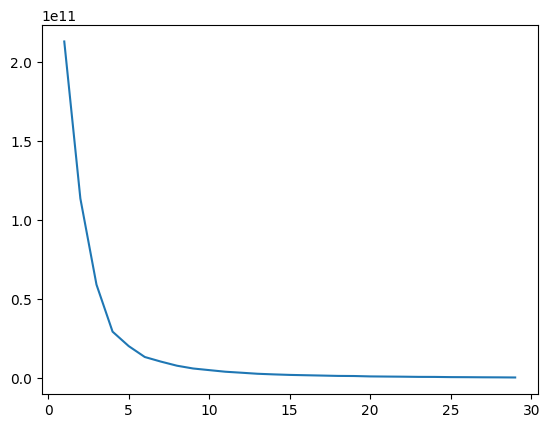

In [78]:
inertias = []
for i in range(1,30):
  kmeans=KMeans(n_clusters=i,init='k-means++')
  kmeans.fit(distance)
  inertias.append(kmeans.inertia_)

plt.plot(range(1,30),inertias)
plt.show()

The elbow is at around k=5.

In [94]:
kmeans=KMeans(n_clusters=10,init='k-means++')
kmeans.fit(distance)
time_labels_kmeans=kmeans.labels_
data_sample_time['time_cluster_kmeans']=time_labels_kmeans

In [95]:
# Initialize the map
m = folium.Map(location=[45.762611, 4.832805], zoom_start=12)

# Assign cluster labels (assuming 'DBlabels' is your clustering result)
labels = time_labels_kmeans

# Group points by cluster
clustered_points = data_sample_time.assign(cluster=labels)

# Define colors for clusters (extendable)
cluster_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#FFA500', '#800080']

# Loop through each point and create a marker with the corresponding color based on the cluster
for _, row in clustered_points.iterrows():
    cluster_id = row['cluster']
    marker_color = cluster_colors[cluster_id % len(cluster_colors)]  # Use modulo for repeating colors

    # Add marker with cluster-specific color
    folium.Marker(
        location=[row["lat"], row["long"]],
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="{marker_color}"/>
        </svg>
        """)
    ).add_to(m)

# Display the map
m
# Save and display the map
m.save("cluster_map_time_kmeans.html")
m

In [96]:
data_sample_time[['time','time_cluster_kmeans']].groupby(by=['time_cluster_kmeans']).mean()/60

time
time_cluster_kmeans           
0                    13.130162
1                    20.205908
2                     0.964559
3                     9.008824
4                    15.046903
5                    22.403462
6                    11.273872
7                    18.312634
8                     5.811333
9                    16.685435

We can see 4 clusters, with mean times more spread out in the day which is logical since using Kmeans. 

In [97]:
data_sample_time[['time','time_cluster_kmeans']].groupby(by=['time_cluster_kmeans']).count()

time
time_cluster_kmeans      
0                     226
1                     189
2                      87
3                     119
4                     296
5                     207
6                     229
7                     248
8                      50
9                     349

Clusters are also more equilibrated.

In [98]:
data_sample_time[['time','time_cluster_kmeans']].groupby(by=['time_cluster_kmeans']).min()/60

time
time_cluster_kmeans           
0                    12.216667
1                    19.266667
2                     0.000000
3                     7.483333
4                    14.100000
5                    21.316667
6                    10.150000
7                    17.516667
8                     3.450000
9                    15.866667

In [99]:
data_sample_time[['time','time_cluster_kmeans']].groupby(by=['time_cluster_kmeans']).max()/60

time
time_cluster_kmeans           
0                    14.083333
1                    21.250000
2                     3.183333
3                    10.133333
4                    15.850000
5                    23.983333
6                    12.183333
7                    19.250000
8                     7.300000
9                    17.500000

Results are coherent, most photos are taken between 4pm and 5pm.
We can look at photos belonging to a specific cluster only on the map, for example cluster 7, between 5.30pm and 19.25pm. 

In [105]:
# Initialize the map
m = folium.Map(location=[45.762611, 4.832805], zoom_start=12)

# Assign cluster labels (assuming 'DBlabels' is your clustering result)
labels = time_labels_kmeans

# Group points by cluster
clustered_points = data_sample_time.assign(cluster=labels)

# Define colors for clusters (extendable)
cluster_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#FFA500', '#800080']

# Loop through each point and create a marker with the corresponding color based on the cluster
for _, row in clustered_points.iterrows():
    cluster_id = row['cluster']
    if(cluster_id!=7): continue
    marker_color = cluster_colors[0]  

    # Add marker with cluster-specific color
    folium.Marker(
        location=[row["lat"], row["long"]],
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="{marker_color}"/>
        </svg>
        """)
    ).add_to(m)

# Display the map
m
# Save and display the map
m.save("cluster_map_time_kmeans.html")
m

Unfortunately, we notice that photos are distributed similarly in all different time clusters throughout the day. This analysis will not be able to help the city of Lyon to better manage flows. 